In [1]:
import os
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil
import pandas as pd

# loading and visualizing the dataset

In [2]:
image_dir = '/kaggle/input/face-mask-detection/images'
annotation_dir = '/kaggle/input/face-mask-detection/annotations'


image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
annotation_files = sorted([f for f in os.listdir(annotation_dir) if f.endswith(".xml")])

print(f"Total Images: {len(image_files)}")
print(f"Total Annotations: {len(annotation_files)}")

Total Images: 853
Total Annotations: 853


In [3]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_data = []

    filename = root.find("filename").text

    for obj in root.findall("object"):
        label = obj.find("name").text

        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        image_data.append({
            "filename": filename,
            "label": label,
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax
        })

    return image_data

# Load all annotation data
annotations = []
for file in annotation_files:
    full_path = os.path.join(annotation_dir, file)
    annotations.extend(parse_annotation(full_path))

# Convert to DataFrame
df = pd.DataFrame(annotations)
print(df.head())


            filename         label  xmin  ymin  xmax  ymax
0  maksssksksss0.png  without_mask    79   105   109   142
1  maksssksksss0.png     with_mask   185   100   226   144
2  maksssksksss0.png  without_mask   325    90   360   141
3  maksssksksss1.png     with_mask   321    34   354    69
4  maksssksksss1.png     with_mask   224    38   261    73


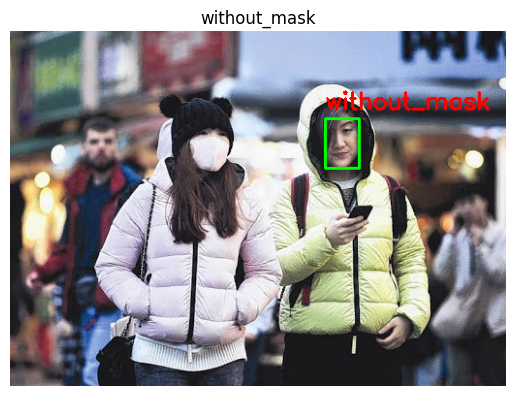

In [4]:
def show_image_with_bbox(index):
    row = df.iloc[index]
    image_path = os.path.join(image_dir, row["filename"])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cv2.rectangle(image, 
                  (row["xmin"], row["ymin"]), 
                  (row["xmax"], row["ymax"]), 
                  (0, 255, 0), 2)

    label = row["label"]
    cv2.putText(image, label, (row["xmin"], row["ymin"] - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    plt.imshow(image)
    plt.axis("off")
    plt.title(label)
    plt.show()

# Visualize one sample
show_image_with_bbox(2)


# Prepare the Dataset for Training

In [5]:
unique_images = df["filename"].unique()


train_imgs, test_imgs = train_test_split(unique_images, test_size=0.1, random_state=42)
train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.1, random_state=42)

def create_dirs(base_path="yolo_dataset"):
    for split in ["train", "val", "test"]:
        os.makedirs(f"{base_path}/images/{split}", exist_ok=True)
        os.makedirs(f"{base_path}/labels/{split}", exist_ok=True)

create_dirs()

In [6]:
# Class map
class_map = {
    "with_mask": 0,
    "without_mask": 1,
    "mask_weared_incorrect": 2
}

def convert_to_yolo(row, img_width, img_height):
    x_center = (row["xmin"] + row["xmax"]) / 2 / img_width
    y_center = (row["ymin"] + row["ymax"]) / 2 / img_height
    width = (row["xmax"] - row["xmin"]) / img_width
    height = (row["ymax"] - row["ymin"]) / img_height
    return f"{class_map[row['label']]} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

def save_annotations(split_images, split_name):
    for filename in split_images:
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        # Save image to new location
        shutil.copy(img_path, f"yolo_dataset/images/{split_name}/{filename}")

        # Get all annotations for this image
        rows = df[df["filename"] == filename]
        label_file = filename.replace(".png", ".txt")
        with open(f"yolo_dataset/labels/{split_name}/{label_file}", "w") as f:
            for _, row in rows.iterrows():
                yolo_line = convert_to_yolo(row, w, h)
                f.write(yolo_line + "\n")

# Save annotations
save_annotations(train_imgs, "train")
save_annotations(val_imgs, "val")
save_annotations(test_imgs, "test")


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


# Train YOLOv5

In [7]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3

In [8]:
!ls /kaggle/working/yolo_dataset/


images	labels


In [9]:
data_yaml = """
train: /kaggle/working/yolo_dataset/images/train
val: /kaggle/working/yolo_dataset/images/val
test: /kaggle/working/yolo_dataset/images/test

nc: 3
names: ["with_mask", "without_mask", "mask_weared_incorrect"]
"""

with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as f:
    f.write(data_yaml)


In [10]:
from ultralytics import YOLO

# Load a YOLOv8 model (you can also try yolov8n, yolov8s, yolov8m, yolov8l)
model = YOLO("yolov8n.pt")  # Using the nano version for faster training

# Train the model
model.train(data="/kaggle/working/yolo_dataset/data.yaml", epochs=50, imgsz=640, batch=16)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 86.5MB/s]


Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3035.4±1510.8 MB/s, size: 474.5 KB)


train: Scanning /kaggle/working/yolo_dataset/labels/train... 690 images, 0 backgrounds, 0 corrupt: 100%|██████████| 690/690 [00:01<00:00, 504.08it/s]

train: New cache created: /kaggle/working/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1268.5±1571.3 MB/s, size: 495.6 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val... 77 images, 0 backgrounds, 0 corrupt: 100%|██████████| 77/77 [00:00<00:00, 426.50it/s]

val: New cache created: /kaggle/working/yolo_dataset/labels/val.cache



libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.55G      1.786      2.843       1.39         97        640:  89%|████████▊ | 39/44 [00:09<00:00,  5.25it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       1/50       2.6G      1.728        2.7      1.354         18        640: 100%|██████████| 44/44 [00:10<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         77        358      0.993     0.0569      0.283      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.85G      1.335       1.45      1.067        166        640:  89%|████████▊ | 39/44 [00:08<00:00,  5.30it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       2/50      2.85G      1.343       1.45      1.083          6        640: 100%|██████████| 44/44 [00:08<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]

                   all         77        358      0.536      0.236      0.361      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.88G      1.285      1.209      1.053         16        640: 100%|██████████| 44/44 [00:08<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

                   all         77        358      0.398       0.37      0.383      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.88G       1.28      1.158      1.051         85        640:  68%|██████▊   | 30/44 [00:05<00:02,  4.96it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       4/50       2.9G      1.282      1.143       1.05         11        640: 100%|██████████| 44/44 [00:08<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]

                   all         77        358      0.826      0.458       0.54      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.9G      1.253      1.047       1.03        210        640:  36%|███▋      | 16/44 [00:03<00:05,  4.93it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       5/50       2.9G      1.229      1.042      1.026        133        640:  89%|████████▊ | 39/44 [00:07<00:01,  4.59it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       5/50      2.92G      1.232      1.033      1.029         15        640: 100%|██████████| 44/44 [00:08<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         77        358      0.677      0.553      0.604      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.93G      1.179     0.9645       1.03          9        640: 100%|██████████| 44/44 [00:08<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]

                   all         77        358      0.594      0.537      0.567      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.93G      1.165     0.9159      1.015         80        640:  80%|███████▉  | 35/44 [00:06<00:01,  5.25it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       7/50      2.95G      1.168     0.9208      1.012          7        640: 100%|██████████| 44/44 [00:08<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]

                   all         77        358      0.706      0.656      0.655      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.95G      1.183     0.8782      1.003        101        640:  66%|██████▌   | 29/44 [00:05<00:02,  5.30it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       8/50      2.97G      1.184     0.8671      1.005         20        640: 100%|██████████| 44/44 [00:08<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.91it/s]

                   all         77        358      0.699      0.618      0.619      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.97G      1.155     0.8536      1.022         80        640:  80%|███████▉  | 35/44 [00:07<00:01,  5.03it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       9/50      2.98G      1.159     0.8538      1.014         33        640: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all         77        358      0.839      0.465      0.628      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.98G      1.148     0.8148     0.9924        119        640:  75%|███████▌  | 33/44 [00:06<00:02,  5.26it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      10/50         3G      1.141     0.8095     0.9885          9        640: 100%|██████████| 44/44 [00:08<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         77        358      0.902      0.618       0.72      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         3G      1.148     0.7924     0.9952        128        640:  66%|██████▌   | 29/44 [00:05<00:02,  5.29it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      11/50      3.02G      1.151     0.7981     0.9964         74        640: 100%|██████████| 44/44 [00:08<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

                   all         77        358      0.782      0.693      0.752      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.02G      1.152     0.7582     0.9911        176        640:  61%|██████▏   | 27/44 [00:05<00:03,  5.38it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      12/50      3.03G      1.147     0.7646     0.9936          7        640: 100%|██████████| 44/44 [00:08<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

                   all         77        358       0.79      0.657      0.726      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.03G     0.9918     0.6523     0.9787        106        640:   0%|          | 0/44 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      13/50      3.03G      1.115     0.7497     0.9949         95        640:  91%|█████████ | 40/44 [00:07<00:00,  5.26it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      13/50      3.05G      1.117     0.7529      1.002          7        640: 100%|██████████| 44/44 [00:08<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all         77        358      0.776      0.698      0.734      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.32G      1.093     0.7416     0.9881          6        640: 100%|██████████| 44/44 [00:08<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

                   all         77        358      0.906       0.63      0.742       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.32G      1.141      0.713     0.9972         97        640:  18%|█▊        | 8/44 [00:01<00:07,  5.13it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      15/50      3.34G      1.107     0.7292     0.9897         34        640: 100%|██████████| 44/44 [00:08<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

                   all         77        358      0.944      0.668       0.78      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.34G      1.072     0.7251      1.016         97        640:   2%|▏         | 1/44 [00:00<00:07,  5.38it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      16/50      3.34G      1.085     0.6814      0.974        112        640:  93%|█████████▎| 41/44 [00:08<00:00,  5.27it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      16/50      3.35G      1.086     0.6873     0.9805          7        640: 100%|██████████| 44/44 [00:08<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all         77        358      0.806      0.756      0.767      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.63G      1.103     0.7537      1.001          3        640: 100%|██████████| 44/44 [00:08<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

                   all         77        358      0.744      0.811      0.779      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.63G      1.078     0.6905     0.9773        138        640:  66%|██████▌   | 29/44 [00:05<00:02,  5.13it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      18/50      3.65G      1.085      0.689     0.9758          7        640: 100%|██████████| 44/44 [00:08<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.72it/s]

                   all         77        358      0.859      0.625      0.738      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.67G      1.064      0.682     0.9691         23        640: 100%|██████████| 44/44 [00:08<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

                   all         77        358      0.618      0.748      0.712      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.67G      1.036     0.6377     0.9529        121        640:   9%|▉         | 4/44 [00:00<00:08,  4.99it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      20/50      3.67G      1.062      0.668     0.9636        141        640:  95%|█████████▌| 42/44 [00:08<00:00,  5.41it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      20/50      3.69G      1.066     0.6677     0.9631         10        640: 100%|██████████| 44/44 [00:08<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.18it/s]

                   all         77        358      0.717      0.786      0.749       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.71G      1.081     0.6665     0.9804         13        640: 100%|██████████| 44/44 [00:08<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

                   all         77        358      0.775      0.773      0.831      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.71G      1.041      0.634     0.9597        114        640:  20%|██        | 9/44 [00:01<00:06,  5.39it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      22/50      3.72G      1.071     0.6548     0.9667         12        640: 100%|██████████| 44/44 [00:08<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]

                   all         77        358      0.896      0.723       0.85      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.72G      1.061     0.6413     0.9709        108        640:  75%|███████▌  | 33/44 [00:06<00:02,  5.10it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      23/50      3.74G      1.051      0.636     0.9698         16        640: 100%|██████████| 44/44 [00:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]

                   all         77        358      0.876      0.773      0.878      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.74G      1.049     0.6134     0.9541        103        640:  11%|█▏        | 5/44 [00:00<00:07,  5.39it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      24/50      4.09G      1.048     0.6234     0.9641         18        640: 100%|██████████| 44/44 [00:08<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]

                   all         77        358      0.844      0.816      0.803      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.09G       1.02     0.6095     0.9521         93        640:  23%|██▎       | 10/44 [00:01<00:06,  5.34it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      25/50      4.11G      1.022     0.6104     0.9578         22        640: 100%|██████████| 44/44 [00:08<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         77        358       0.75      0.913      0.843      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.11G       1.06     0.6291     0.9822         64        640:  25%|██▌       | 11/44 [00:02<00:06,  5.37it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      26/50      4.13G      1.031     0.6082     0.9622         11        640: 100%|██████████| 44/44 [00:08<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         77        358      0.775      0.808      0.824      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.13G      1.083     0.6338     0.9584         93        640:   7%|▋         | 3/44 [00:00<00:07,  5.52it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      27/50      4.14G       1.01     0.5901     0.9526          9        640: 100%|██████████| 44/44 [00:08<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.25it/s]

                   all         77        358       0.83      0.778      0.846      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.14G      1.046     0.6303     0.9735         72        640:  16%|█▌        | 7/44 [00:01<00:06,  5.53it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      28/50      4.16G      1.017     0.5984      0.955         22        640: 100%|██████████| 44/44 [00:08<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         77        358       0.86      0.753      0.821      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.16G      1.027     0.5896     0.9597        125        640:  66%|██████▌   | 29/44 [00:05<00:02,  5.31it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      29/50      4.18G      1.017     0.5897     0.9574         18        640: 100%|██████████| 44/44 [00:08<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.59it/s]

                   all         77        358      0.853      0.853      0.893      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.18G      1.118     0.6217     0.9457        177        640:   7%|▋         | 3/44 [00:00<00:07,  5.53it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      30/50       4.2G      1.022     0.5783     0.9503         18        640: 100%|██████████| 44/44 [00:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.25it/s]

                   all         77        358      0.798      0.789      0.838      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       4.2G     0.9502     0.5496     0.9413        114        640:  48%|████▊     | 21/44 [00:03<00:04,  5.32it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      31/50       4.2G     0.9801     0.5604     0.9439        159        640:  91%|█████████ | 40/44 [00:07<00:00,  5.11it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      31/50      4.21G     0.9793     0.5722     0.9535          2        640: 100%|██████████| 44/44 [00:08<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]

                   all         77        358      0.934      0.761      0.892      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.23G     0.9844     0.5546     0.9432         16        640: 100%|██████████| 44/44 [00:08<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

                   all         77        358      0.886       0.82      0.895      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.23G     0.9709     0.5573     0.9434         93        640:  64%|██████▎   | 28/44 [00:05<00:03,  5.03it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      33/50      4.25G     0.9843     0.5631     0.9422         17        640: 100%|██████████| 44/44 [00:08<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]

                   all         77        358      0.856      0.835      0.883      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.25G      1.015     0.5518      0.949        110        640:  27%|██▋       | 12/44 [00:02<00:06,  5.20it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      34/50      4.26G     0.9866     0.5596     0.9641          6        640: 100%|██████████| 44/44 [00:08<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

                   all         77        358      0.846      0.742      0.856      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.26G      1.011     0.5658     0.9419        173        640:  16%|█▌        | 7/44 [00:01<00:06,  5.39it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      35/50      4.28G     0.9606     0.5452     0.9398          3        640: 100%|██████████| 44/44 [00:08<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]

                   all         77        358      0.952      0.777      0.879        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.28G     0.9589     0.5387     0.9304        189        640:  52%|█████▏    | 23/44 [00:04<00:03,  5.36it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      36/50      4.29G       0.96     0.5556     0.9363          8        640: 100%|██████████| 44/44 [00:08<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]

                   all         77        358      0.828      0.769       0.86      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.29G     0.9212     0.5052     0.9377        133        640:  23%|██▎       | 10/44 [00:01<00:06,  5.41it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      37/50      4.31G     0.9735     0.5378     0.9411          5        640: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         77        358      0.876      0.783      0.868      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.31G     0.9315     0.5277     0.9339        119        640:  18%|█▊        | 8/44 [00:01<00:06,  5.28it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      38/50      4.33G     0.9076     0.5071     0.9244         14        640: 100%|██████████| 44/44 [00:08<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]

                   all         77        358      0.815      0.878      0.897      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.33G     0.9907     0.5343     0.9276        243        640:  36%|███▋      | 16/44 [00:02<00:05,  5.24it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      39/50      4.35G     0.9687     0.5254     0.9313         25        640: 100%|██████████| 44/44 [00:08<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

                   all         77        358      0.835      0.771      0.864       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.35G     0.9593     0.5252     0.9296        166        640:  50%|█████     | 22/44 [00:04<00:04,  5.32it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      40/50      4.35G     0.9607     0.5217     0.9312        147        640:  86%|████████▋ | 38/44 [00:07<00:01,  5.00it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      40/50      4.36G     0.9612      0.523     0.9301         19        640: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         77        358      0.964      0.753      0.893       0.63


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.36G     0.9536     0.5337     0.9258         59        640:  36%|███▋      | 16/44 [00:04<00:05,  5.04it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      41/50      4.38G     0.9306     0.5007     0.9228          2        640: 100%|██████████| 44/44 [00:09<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all         77        358      0.799      0.876      0.875      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.38G     0.9951     0.5255     0.9247         76        640:   5%|▍         | 2/44 [00:00<00:07,  5.68it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      42/50       4.4G     0.9151     0.4859     0.9176          2        640: 100%|██████████| 44/44 [00:08<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]

                   all         77        358      0.774      0.863      0.871      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       4.4G     0.9684     0.5307      0.937         32        640:  20%|██        | 9/44 [00:01<00:06,  5.45it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      43/50      4.41G     0.9274     0.4863     0.9241          4        640: 100%|██████████| 44/44 [00:08<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all         77        358      0.825      0.839      0.864      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.43G     0.9063     0.4738     0.9133          3        640: 100%|██████████| 44/44 [00:08<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         77        358      0.905      0.818      0.896      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.43G     0.9222     0.4747     0.9373         55        640:   5%|▍         | 2/44 [00:00<00:07,  5.44it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      45/50      4.45G     0.9056     0.4685     0.9062         23        640: 100%|██████████| 44/44 [00:08<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]

                   all         77        358      0.893      0.728      0.849      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.45G     0.8885     0.4546     0.9031         40        640:  55%|█████▍    | 24/44 [00:04<00:03,  5.26it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      46/50      4.46G      0.879     0.4532     0.9081          2        640: 100%|██████████| 44/44 [00:08<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]

                   all         77        358      0.741      0.832      0.825      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.46G     0.9525     0.5028     0.9136         72        640:  14%|█▎        | 6/44 [00:01<00:07,  5.25it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      47/50      4.48G     0.8778     0.4525     0.8996          3        640: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]

                   all         77        358       0.77      0.878      0.857      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.48G     0.8765     0.4779     0.9069         57        640:  14%|█▎        | 6/44 [00:01<00:07,  5.37it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      48/50      4.48G     0.8737     0.4513     0.9024         71        640:  89%|████████▊ | 39/44 [00:07<00:00,  5.48it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      48/50       4.5G     0.8769     0.4529     0.9025          6        640: 100%|██████████| 44/44 [00:08<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]

                   all         77        358      0.801      0.818      0.849       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.52G     0.8758     0.4505      0.903         19        640: 100%|██████████| 44/44 [00:08<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]

                   all         77        358      0.804      0.811      0.869      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.52G     0.8854     0.4475     0.8941         80        640:  45%|████▌     | 20/44 [00:03<00:04,  5.22it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      50/50      4.52G      0.879     0.4427     0.8955         67        640:  82%|████████▏ | 36/44 [00:06<00:01,  4.78it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      50/50      4.54G     0.8807     0.4431     0.8959          8        640: 100%|██████████| 44/44 [00:08<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

                   all         77        358      0.802      0.814      0.858      0.594



50 epochs completed in 0.130 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


                   all         77        358      0.965      0.753      0.894       0.63
             with_mask         70        272      0.967      0.886      0.968      0.693
          without_mask         27         79      0.927      0.671      0.887      0.565
 mask_weared_incorrect          7          7          1      0.703      0.825      0.633


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 3.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cf1cc090d90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [11]:
#Image(filename="/kaggle/working/runs/detect/train2/PR_curve.png")

In [12]:
#Image(filename="/kaggle/working/runs/detect/train2/P_curve.png")

In [13]:
#Image(filename="/kaggle/working/runs/detect/train2/R_curve.png")

In [14]:
#Image(filename="/kaggle/working/runs/detect/train2/confusion_matrix.png")

In [15]:
#Image(filename="/kaggle/working/runs/detect/train2/confusion_matrix_normalized.png")

In [16]:
#Image(filename="/kaggle/working/runs/detect/train2/labels.jpg")

In [17]:
#Image(filename="/kaggle/working/runs/detect/train2/labels_correlogram.jpg")

In [18]:
#Image(filename="/kaggle/working/runs/detect/train2/results.png")

In [19]:
metrics = model.val()


Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4020.7±874.2 MB/s, size: 487.8 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 77 images, 0 backgrounds, 0 corrupt: 100%|██████████| 77/77 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


                   all         77        358      0.967       0.76      0.894      0.622
             with_mask         70        272      0.969      0.882       0.97      0.692
          without_mask         27         79      0.932      0.693      0.876      0.558
 mask_weared_incorrect          7          7          1      0.705      0.835      0.615


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.4ms preprocess, 16.8ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/train2
